# **Introduction**

Continued from Part 3.1. This notebook will get the covid time data first and then do the grouby and merge and add the average per building per year column for further analysis.

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row', 1000)

# **Part 1 Get the Eviction data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data source:
# get the covid time data directly
file_path = '/content/drive/My Drive/X999/evictions_covid.csv'

In [7]:
evictions_df_covid_raw = pd.read_csv(file_path)

In [8]:
evictions_df_covid = evictions_df_covid_raw.copy()

In [9]:
evictions_df_covid.bin = evictions_df_covid.bin.astype(int)
evictions_df_covid.bbl = evictions_df_covid.bbl.astype(int)

In [10]:
evictions_df_covid.shape
# correct

(6564, 21)

In [11]:
evictions_df_covid.head(2)

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,...,longitude,community_board,council_district,census_tract,bin,bbl,nta,year,month_year,geometry
0,004123/20_209969,004123/20,209969,2541 A GRAND AVE,ROOM 3B,2022-08-22,BRONX,10468,Not an Ejectment,Possession,...,-73.901317,7.0,14.0,265.0,2113173,2032140141,Kingsbridge Heights,2022,2022-08,POINT (-73.901317 40.865396)
1,0050153/20_106030,0050153/20,106030,98-05 67TH AVENUE,12F,2022-04-14,QUEENS,11375,Not an Ejectment,Possession,...,-73.855552,6.0,29.0,71306.0,4074666,4031560133,Forest Hills,2022,2022-04,POINT (-73.855552 40.724241)


In [12]:
evictions_df_covid.columns, \
evictions_df_covid.shape

(Index(['primary_key', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'eviction_postcode', 'ejectment',
        'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
        'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
        'month_year', 'geometry'],
       dtype='object'),
 (6564, 21))

In [15]:
evictions_df_covid.executed_date = pd.to_datetime(evictions_df_covid.executed_date)

In [14]:
# evictions_df_covid.executed_date.dtype

dtype('O')

In [18]:
evictions_df_covid.executed_date.min(), evictions_df_covid.executed_date.max()

(Timestamp('2020-01-02 00:00:00'), Timestamp('2022-12-28 00:00:00'))

# **From now on, everything is about covid times**

# **Part 2: Aggregation to find eviction counts (with BIN)**

#### Aggregate by bin:

BIN (buiding identification numbers) appears to be the most sensible basic unit here, as other ones: apartment unit, neighborhood, zipcode, and borough would either be too small (non-representable) or too large to understand landlord behaviors.

## **A tiny note on groupby and merge:**
### One tricky thing is when we do the groupby and merge to calcuate per building per year's eviction, we're finding one average evictions per year value for each unique building. When we merge this value back to the original df, we want all rows that have the same bin get the same avg_evictions_per_building value. If we groupby 'bin', 'year', and have the numb_years, each bin will be divided by different number of years (the number of years that they had evictions), and therefore it is different from groupby bin and directly divide by 5.
### This is a big distinction, because groupby bin and year, and divide by the years each building had eviction assumes that when the building did not have evictions that year, the buildings did not exist. This is not true. We need to treat as if all the buildings exist in all these years.
### Since bbl data has a cutoff at 2020 (something we learned from another dataset), we will not go into details to think about "what if certain buildings were completed in 2019 and did not exist in 2017" this type of questions.

In [ ]:
# evictions_by_building_year = evictions_df.groupby(['bin', 'year']).size().reset_index(name='evictions')
# years_per_building = evictions_by_building_year.groupby('bin')['year'].nunique()
# total_evictions = evictions_by_building_year.groupby('bin')['evictions'].sum()
# avg_evictions = total_evictions / years_per_building
# # don't do this

In [19]:
# groupby
evictions_per_building = evictions_df_covid.groupby('bin').size().reset_index(name='total_evictions')

In [20]:
# divide by all years covered
evictions_per_building['average_year_eviction_count'] = evictions_per_building['total_evictions'] / 5

In [22]:
# merge the average_year_eviction_count back to the evictions_df based on bin
evictions_df_covid = evictions_df_covid.merge(evictions_per_building[['bin', 'average_year_eviction_count']], on='bin', how='left')

In [25]:
evictions_df_covid.shape, len(evictions_df_covid.bin.unique())
# not that buildings had more than one evictions during covid

((6564, 22), 5326)

In [24]:
evictions_df_covid.head()

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,...,community_board,council_district,census_tract,bin,bbl,nta,year,month_year,geometry,average_year_eviction_count
0,004123/20_209969,004123/20,209969,2541 A GRAND AVE,ROOM 3B,2022-08-22,BRONX,10468,Not an Ejectment,Possession,...,7.0,14.0,265.0,2113173,2032140141,Kingsbridge Heights,2022,2022-08,POINT (-73.901317 40.865396),0.2
1,0050153/20_106030,0050153/20,106030,98-05 67TH AVENUE,12F,2022-04-14,QUEENS,11375,Not an Ejectment,Possession,...,6.0,29.0,71306.0,4074666,4031560133,Forest Hills,2022,2022-04,POINT (-73.855552 40.724241),0.2
2,0052002/19_101926,0052002/19,101926,199 VERONICA PLACE,1ST FLOOR,2020-03-02,BROOKLYN,11226,Not an Ejectment,Possession,...,17.0,40.0,792.0,3117969,3051370021,Erasmus,2020,2020-03,POINT (-73.952578 40.645404),0.6
3,0057757/18_100889,0057757/18,100889,302 EASTERN PARKWAY,4B,2020-02-03,BROOKLYN,11225,Not an Ejectment,Possession,...,9.0,35.0,213.0,3029673,3011850034,Crown Heights South,2020,2020-02,POINT (-73.958843 40.670832),0.8
4,0058466/19_104327,0058466/19,104327,635 WEST 42ND STREET,UNIT 18B,2020-03-12,MANHATTAN,10036,Not an Ejectment,Possession,...,4.0,3.0,129.0,1087539,1010907501,Clinton,2020,2020-03,POINT (-73.999816 40.761463),0.2


In [26]:
evictions_per_building.shape
# correct 38502

(5326, 3)

In [ ]:
# evictions_cleaned.to_csv('/content/drive/My Drive/X999/evictions_geo_cleaned_all.csv', index=False)

# **Part 3 Eviction trends over time and over different buildings**

## **Only covid times in this file**

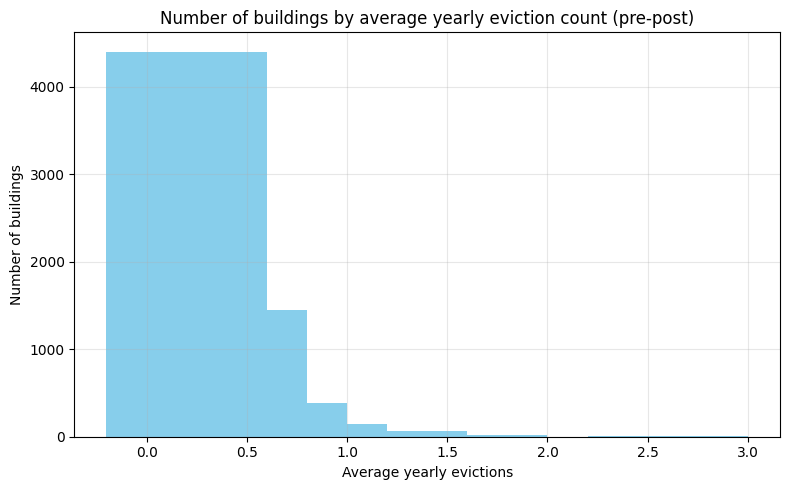

In [27]:
eviction_counts = evictions_df_covid['average_year_eviction_count'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(eviction_counts.index, eviction_counts.values, color='skyblue')

plt.title('Number of buildings by average yearly eviction count (pre-post)', fontsize=12)
plt.xlabel('Average yearly evictions')
plt.ylabel('Number of buildings')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# create stats
total_buildings = eviction_counts.sum()
buildings_one_eviction = eviction_counts.get(1.0, 0)
percentage_one_eviction = (buildings_one_eviction / total_buildings) * 100

In [28]:
# get the metrics first
most_common_count = eviction_counts.index[eviction_counts.argmax()]
buildings_less_equal_common = (evictions_per_building['average_year_eviction_count'] <= most_common_count).sum()
percentage_less_equal_common = (buildings_less_equal_common / total_buildings) * 100

In [29]:
most_common_count, buildings_less_equal_common, percentage_less_equal_common

(np.float64(0.2), np.int64(4404), np.float64(67.09323583180988))

In [30]:
summary_data = {'metrics': ['total buildings', 'most common eviction count (per building, per year)',
  'buildings with exactly one eviction per year', 'buildings with less than most common eviction count (per building, per year)'],
'value': [f"{total_buildings:,}", f"{most_common_count:.2f} ({eviction_counts.max():,} buildings)",
f"{buildings_one_eviction:,} ({percentage_one_eviction:.1f}%)",f"{buildings_less_equal_common:,} ({percentage_less_equal_common:.1f}%)"]}

summary_df = pd.DataFrame(summary_data)
summary_df

,metrics,value
0,total buildings,"6,564"
1,"most common eviction count (per building, per year)","0.20 (4,404 buildings)"
2,buildings with exactly one eviction per year,65 (1.0%)
3,"buildings with less than most common eviction count (per building, per year)","4,404 (67.1%)"


In [33]:
evictions_df_covid['average_year_eviction_count'].mean()

np.float64(0.30938452163315056)

## Outside of covid the average_year_eviction_count per building was 1.24. A big difference.

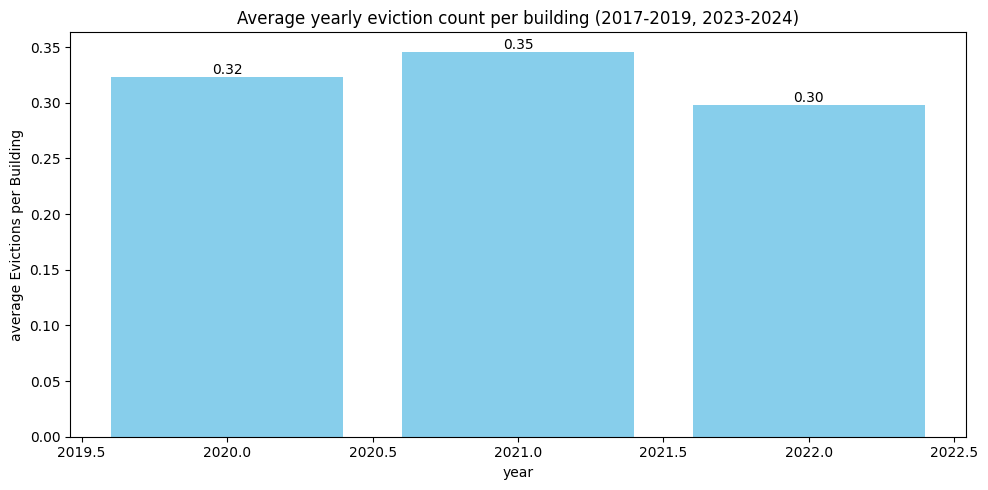

In [34]:
yearly_means = evictions_df_covid.groupby('year')['average_year_eviction_count'].mean()

plt.figure(figsize=(10, 5))
bars = plt.bar(yearly_means.index, yearly_means.values, color='skyblue')

plt.title('Average yearly eviction count per building (2017-2019, 2023-2024)', fontsize=12)
plt.xlabel('year')
plt.ylabel('average Evictions per Building')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [35]:
combined_stats = {
    'metric': ['overall mean', f'maximum average ({yearly_means.idxmax()})',
        f'minimum average ({yearly_means.idxmin()})'] + [f"average for {year}" for year in yearly_means.index],
    'value': [f"{yearly_means.mean():.2f}",
  f"{yearly_means.max():.2f}",f"{yearly_means.min():.2f}"] + [f"{avg:.2f}" for avg in yearly_means.values]}

In [37]:
combined_df = pd.DataFrame(combined_stats)
combined_df
# very different from normal times.

,metric,value
0,overall mean,0.32
1,maximum average (2021),0.35
2,minimum average (2022),0.30
3,average for 2020,0.32
4,average for 2021,0.35
5,average for 2022,0.30


# **Part 4 Visualize the GeoDataFrame -- Plotly and Folium**

## **Part 4.1 Plotly first pre-post covid**


In [8]:
# scatter map showing eviction counts by BIN
# a very basic and high-level visualization of each building's annual eviction during the year pre and post covid
# the outlines are clear. They are the lighter and orange ones.
fig = px.scatter_geo(evictions_df_covid,
                     lat='latitude', lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bin',
                     title="Evictions by bin in NYC pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [7]:
# not let the ones < 5 shown
evictions_filtered = evictions_df_covid[evictions_df_covid['average_year_eviction_count'] >= 1]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bin',
                     title="Evictions by bin in NYC (1+ Evictions) pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [ ]:
# # in case the graph does not load, it is as shown below
# # it is originally an interactive graph where if you point to a building, you get the bin id, laititude, longitude, and
# # the annual eviction counts
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
# Image(filename='plotly_image.png')

In [ ]:
# # save as an interactive HTML file
# pio.write_html(fig, file='evictions_map.html', auto_open=False)

#### Short summaries:  
- During covid, buildings with high evictions were drastically fewer than normal times. And the buildings with high evictions were consistent with the normal times'.[link text](https://)


## **Part 4.2 Folium pre-post covid**

In [6]:
# use folium heatmap to show the data in a better visualization
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (all buildings with evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']] for index, row in evictions_df_covid.iterrows()]
HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [5]:
# not let the ones < 5 shown
evictions_filtered = evictions_df_covid[evictions_df_covid['average_year_eviction_count'] >= 1]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# html
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (5+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [47]:
# # not let the ones < 10 shown
# evictions_filtered = evictions_df_covid[evictions_df_covid['average_year_eviction_count'] >= 10]

# nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# # HTML
# title_html = '''
#              <div style="position: fixed;
#                          top: 10px;
#                          left: 50%;
#                          transform: translateX(-50%);
#                          z-index: 1000;
#                          background-color: white;
#                          padding: 10px;
#                          border-radius: 5px;
#                          border: 2px solid grey;
#                          font-size: 16px;
#                          font-weight: bold;">
#                  NYC Evictions Heatmap pre post covid (10+ Evictions per building)
#              </div>
#              '''
# nyc_map.get_root().html.add_child(folium.Element(title_html))

# heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
#              for index, row in evictions_filtered.iterrows()]

# HeatMap(heat_data, radius=10).add_to(nyc_map)

# nyc_map

In [ ]:
# # in case it does not load, it is as shown below
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
# Image(filename='heat_map.png')

#### Short summaries:
- Based on the analysis of NYC eviction data in two periods (covid in another file), there's a clear distinction between eviction patterns during and outside of the covid period. In the pre/post covid years (2017-2019, 2023-2024), evictions had a higher rate, with more buildings affected and a higher average number of evictions per building. During the Covid period (2020-2022), there was a significant decrease in eviction activity, likely due to eviction moratoriums and other protective measures implemented during the pandemic, and a decrease in rents with many residents fleeing NYC. This is interesting, as it is consistent with the phenomenon that lower rents/less competitive environment overall actually suppress evictions.

- In both periods, the majority of buildings experienced just one eviction per year, suggesting that most landlords use eviction as an occasional rather than frequent measure. However, there were some properties with notably higher eviction counts, particularly in the normal years. These concentrated areas also tend to be the regular buildings and neighborhoods who show persistent behaviors over the years.

- Foliums shows clear geo relationships with the NYC background. Plotly shows the drastic change with less background distractions.

# **Part 5 Buildings with high evictions in normal times**

In [ ]:
# evictions_cleaned.columns
## didn't change

In [48]:
len(evictions_df_covid.bin.unique())

5326

In [49]:
evictions_df_covid.bin.dtype

dtype('int64')

In [59]:
# sort by eviction_count and extract the top 20 records based on the average_year_eviction_count column
top_bins_pre_post = evictions_df_covid[['bin', 'average_year_eviction_count']].groupby('bin').mean().sort_values(by='average_year_eviction_count', ascending=False)
top_bins_pre_post.shape

(5326, 1)

In [60]:
top_bins_pre_post.head(20)

,average_year_eviction_count
bin,
3000000,2.6
5158986,1.6
4298968,1.6
3319475,1.4
1000000,1.4
3326600,1.2
5112952,1.2
2063299,1.2
5001170,1.2


In [61]:
bins_over_1_evictions = top_bins_pre_post[top_bins_pre_post['average_year_eviction_count'] >= 1]
bins_over_1_evictions.shape
# 18 buildings have eviction counts larger than 10 per year on average

(28, 1)

In [55]:
bins_over_1_evictions

,average_year_eviction_count
bin,
3000000,2.6
5158986,1.6
4298968,1.6
3319475,1.4
1000000,1.4
3326600,1.2
5112952,1.2
2063299,1.2
5001170,1.2


### TODO:
### Some potential research questions/hypothesis include:
    - look into each of these buildings and check who the landlords are. (with the merge of BBL)
    - are they individual landlord or corporate landlords?
    - do they habitually exbihit such behavior?
    - is there a reason for the evictions besides the tenants' behavior?
    - is this related to building policy changes?
    - is this related to city-wide/neighborhood-wide changes?
### Another dataset we will be using: BBL.csv
    - pull the info of the buildings from bbl
    - since there are only 18 of them, we can have a closer look at them and then get a writeup of the landlords' background.

#### The rest of the analysis will be broken down into different notebooks

In [56]:
# save cleaned evictions data to my drive
evictions_df_covid.to_csv('/content/drive/My Drive/X999/evictions_covid.csv', index=False)

In [ ]:
# # save cleaned evictions data to my drive
# evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid.csv', index=False)